Imports

In [7]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 60)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import ndcg_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_regression, SelectFromModel, RFECV
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.wsd import lesk
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
import pickle5 as pkl
import json
import matplotlib.pyplot as plt
import os
import ast
import inspect
from utils import *
import re
from scipy.stats import rankdata, pearsonr, spearmanr, stats
from imblearn.over_sampling import SMOTE
import smogn
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter
import random
from scipy import stats
from functools import partial
import statsmodels.api as sm
import math
from mlxtend.feature_selection import SequentialFeatureSelector

# Incoming from macbook

In [9]:
job = 'pickle'
path = './data/'+job
if not os.path.isdir(path): os.mkdir(path)
if not os.path.isdir(path+'/macbook/'): os.mkdir(path+'/macbook/')
if not os.path.isdir(path+'/colab/'): os.mkdir(path+'/colab/')

# Feature selection

In [10]:
multi_train = pd.read_csv('./data/'+job+'/multi_train_j.tsv', sep='\t', index_col=0)
X = load_features_stacked(job, 'multi_train')
y = multi_train['complexity'].to_numpy()
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_j.tsv', sep='\t', index_col=0)
X_trial = load_features_stacked(job, 'multi_trial')
y_trial = multi_trial['complexity'].to_numpy()

In [11]:
multi_train_feature_name_2_idx = load_feature_name_2_idx(job, 'multi_train')
multi_train_feature_idx_2_name = {value:key for key, value in multi_train_feature_name_2_idx.items()}
multi_trial_feature_name_2_idx = load_feature_name_2_idx(job, 'multi_trial')
multi_trial_feature_idx_2_name = {value:key for key, value in multi_trial_feature_name_2_idx.items()}
feature_names, mi = get_sorted_mi('./data/'+job+'/multi_train_mi.txt')

In [9]:
picks = feature_names[:100]

In [10]:
%%time
n_splits = 5
test_size = 0.1
scoring = {'MAE':make_scorer(MAE), 'pearson':make_scorer(pearson), 'spearman':make_scorer(spearman)}
col_idx = np.array([multi_train_feature_name_2_idx[pick] for pick in picks])
X_picks= X[:, col_idx]
custom_cv = custom_cv_folds(multi_train, n_splits=n_splits, test_size=test_size)
model = LinearRegression()
scores = cross_validate(model, X_picks.astype(float), y, cv=custom_cv, scoring=scoring)
print(np.mean(scores['test_MAE']), np.std(scores['test_MAE']))
print(np.mean(scores['test_pearson']), np.std(scores['test_pearson']))
print(np.mean(scores['test_spearman']), np.std(scores['test_spearman']))

0.07824707310344041 0.004555014752566767
0.7718454409667899 0.021300673250222103
0.7776542404104144 0.02016503811026951
CPU times: user 2.1 s, sys: 6.64 s, total: 8.74 s
Wall time: 313 ms


In [11]:
model = model.fit(X_picks, y)
col_trial_idx = np.array([multi_trial_feature_name_2_idx[pick] for pick in picks])
X_trial_picks = X_trial[:, col_trial_idx]
y_trial_pred = model.predict(X_trial_picks)
MAE(y_trial_pred, y_trial), pearson(y_trial_pred, y_trial), spearman(y_trial_pred, y_trial)

(0.08846834320196961, 0.7226971241416329, 0.7034281448948495)

In [ ]:
test_MAEs, test_pearsons, test_spearmans = [], [], []

In [ ]:
n_splits = 5
test_size = 0.1
for i in tqdm(range(401, 500+1)):
    picks = feature_names[:i]
    col_idx = np.array([multi_train_feature_name_2_idx[pick] for pick in picks])
    X_picks= X[:, col_idx]
    custom_cv = custom_cv_folds(multi_train, n_splits=n_splits, test_size=test_size)
    model = LinearRegression()
    scores = cross_validate(model, X_picks, y, cv=custom_cv, scoring=scoring)
    test_MAEs.append(np.mean(scores['test_MAE']))
    test_pearsons.append(np.mean(scores['test_pearson']))
    test_spearmans.append(np.mean(scores['test_spearman']))

In [ ]:
plt.scatter(range(1, 500), test_pearsons[1:]); plt.plot(range(1, 500), test_pearsons[1:]);

In [ ]:
best_picks = []
best_pearson = 0
for pick in tqdm(feature_names):
    #if pick.startswith(('glove_word', 'glove_context', 'infersent_embeddings', 'elmo_word')):
    #    continue
    if pick.startswith(('glove_context', 'infersent_embeddings')):
        continue
    best_picks.append(pick)
    col_idx = np.array([multi_train_feature_name_2_idx[pick] for pick in best_picks])
    X_picks= X[:, col_idx]
    custom_cv = custom_cv_folds(multi_train, n_splits=n_splits, test_size=test_size)
    model = LinearRegression()
    scores = cross_validate(model, X_picks, y, cv=custom_cv, scoring=scoring)
    t, p = stats.ttest_1samp(scores['test_pearson'], best_pearson)
    #t > 0, p/2 > 0.05 : inconclusive, #t > 0, p/2 < 0.05 : new best pearson
    #t < 0, p/2 > 0.05 : inconclusive, #t < 0, p/2 < 0.05 : remove
    if t > 0 and p/2 < 0.05:
        best_pearson = np.mean(scores['test_pearson'])
    elif t < 0 and p/2 < 0.05:
        del best_picks[-1]
    '''
    #t > 0, p/2 > 0.05 : remove, #t > 0, p/2 < 0.05 : add, new best pearson 
    #t < 0, p/2 > 0.05 : remove, #t < 0, p/2 < 0.05 : remove
    if t > 0 and p/2 < 0.05:
        best_pearson = np.mean(scores['test_pearson'])
    else:
        del best_picks[-1]
    '''

# Playground

In [12]:
#multi_train_mini_idx, multi_dev_mini_idx = next(custom_cv_folds(multi_train, n_splits=1, test_size=0.1))
multi_train_mini_idx, multi_dev_mini_idx = np.load('./data/'+job+'/multi_train_mini_idx.npy'), np.load('./data/'+job+'/multi_dev_mini_idx.npy')
multi_train_mini = multi_train.iloc[multi_train_mini_idx]
multi_dev_mini = multi_train.iloc[multi_dev_mini_idx]
#np.save('./data/pickle/multi_train_mini_idx', multi_train_mini_idx)
#np.save('./data/pickle/multi_dev_mini_idx', multi_dev_mini_idx)
#preprocess_for_bert(multi_train_mini, './data/'+job+'/colab/multi_train_bert.tsv', do_round=False)
#preprocess_for_bert(multi_dev_mini, './data/'+job+'/colab/multi_dev_bert.tsv', do_round=False)

In [13]:
X_train_mini = X[multi_train_mini_idx, :]
X_dev_mini = X[multi_dev_mini_idx, :]
y_train_mini = y[np.array(multi_train_mini_idx)]
y_dev_mini = y[np.array(multi_dev_mini_idx)]

## Filter method: K-best by pearson
Assumptions of pearson:
- Both variables should be normally distributed.
- A straight-line relationship between the two variables.
- Data is equally distributed around the regression line.

In [15]:
k_lst, pearson_lst = [], []

In [ ]:
for k in tqdm(range(1,300+1)):
    k_lst.append(k)
    skb = SelectKBest(score_func=f_regression, k=k)
    skb.fit(X_train_mini, y_train_mini)
    col_idx = skb.get_support(indices=True)
    X_train_mini_picks = X_train_mini[:, col_idx]
    X_dev_mini_picks = X_dev_mini[:, col_idx]
    picks = [multi_train_feature_idx_2_name[support] for support in col_idx]
    model = LinearRegression()
    model = model.fit(X_train_mini_picks, y_train_mini)
    y_dev_mini_pred = model.predict(X_dev_mini_picks)
    pearson_lst.append(pearson(y_dev_mini_pred, y_dev_mini))

Text(0, 0.5, 'pearson')

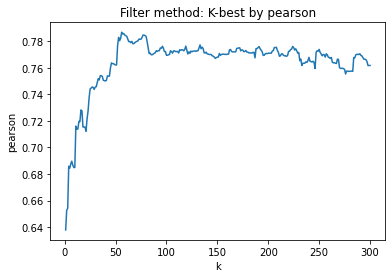

In [19]:
plt.plot(k_lst, pearson_lst)
plt.title('Filter method: K-best by pearson')
plt.xlabel('k')
plt.ylabel('pearson')

In [ ]:
k = 75

## Filter method: K-best by mutual information
- Alternative script in `feature_selection_multi.py`.
- Results below _supposedly_ same as that in `multi_train_mi.txt`.

In [ ]:
#col_2_multi_dim = {'glove_word':300, 'glove_word_sum':300, 'glove_word_head':300, 'glove_word_tail':300, 'glove_context':300, 'infersent_embeddings':4096, 'elmo_word':1024, 'elmo_word_sum':1024, 'elmo_word_head':1024, 'elmo_word_tail':1024}
#single_train = pd.read_csv('./data/'+job+'/single_train_j.tsv', sep='\t', index_col=0)
#discrete_features = discrete(single_train, col_2_multi_dim)

In [ ]:
#skb=SelectKBest(score_func=partial(mutual_info_regression,discrete_features=discrete_features),k=10)
#skb.fit(X_train_mini, y_train_mini)

In [19]:
feature_names, mi = get_sorted_mi('./data/'+job+'/multi_train_mi.txt')
k_lst, pearson_lst = [], []

In [20]:
for k in tqdm(range(1, 300+1)):
    k_lst.append(k)
    picks = feature_names[:k]
    col_idx = [multi_train_feature_name_2_idx[pick] for pick in picks]
    X_train_mini_picks = X_train_mini[:, col_idx]
    X_dev_mini_picks = X_dev_mini[:, col_idx]
    model = LinearRegression()
    model = model.fit(X_train_mini_picks, y_train_mini)
    y_dev_mini_pred = model.predict(X_dev_mini_picks)
    pearson_lst.append(pearson(y_dev_mini_pred, y_dev_mini))

100%|██████████| 300/300 [00:27<00:00, 10.90it/s]


Text(0, 0.5, 'pearson')

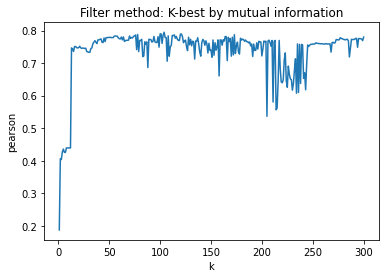

In [21]:
plt.plot(k_lst, pearson_lst)
plt.title('Filter method: K-best by mutual information')
plt.xlabel('k')
plt.ylabel('pearson')

In [ ]:
k = 75

## Wrapped methods: Forward feature selection

In [14]:
picks = feature_names[:75]
col_idx = [multi_train_feature_name_2_idx[pick] for pick in picks]
X_picks = X[:, col_idx]

In [86]:
model = LinearRegression()
sfs = SequentialFeatureSelector(model,
    k_features=30, #should be 75
    forward=True,
    floating=False,
    scoring='r2',
    verbose=2,
    cv=list(custom_cv_folds(multi_train, n_splits=20)),
)

In [87]:
sfs.fit(X_picks, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.9s finished

[2021-01-11 19:40:12] Features: 1/30 -- score: 0.3987827812795866[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    1.8s finished

[2021-01-11 19:40:14] Features: 2/30 -- score: 0.4816692291331318[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    1.9s finished

[2021-01-11 19:40:16] Features: 3/30 -- score: 0.5129799664922342[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(cv=[(array([778, 279, 879, ..., 654, 987, 208]),
                               array([ 173,   34,  348,  263, 1272,  546,  103, 1441,  958,  795,  966,
       1004,  323,   72,  720, 1124,  456,  329,  342,  802,  803,  688,
         93,  452, 1327, 1227, 1019,  489, 1305,  527,  600, 1039, 1178,
         31,  268,  465,  141,  951, 1419, 1505, 1325, 1469, 1083,   65,
          8,  163,  711,  816,  955,  593, 1478,  793,  424, 1304,  945,
        274,  575,  597, 1491, 1352,  536,  845,  164,  702, 1494, 12...
        849,  268,   23, 1452,  969, 1215,  126,  707, 1257,  756,  378,
       1502,  688,  466, 1010, 1157,  318, 1404,  557,  611,  167,  955,
       1505,  360,  224,  293, 1405,  314,  486,  418,  716, 1080, 1419,
        800,   87,  734,  246, 1468,  333,  196,  132, 1236, 1053,  141,
        957, 1444, 1008,  619,  817, 1337,  395, 1019,  683,  263,  273,
        133, 1465,   81,  353,  998,  748,  620, 1216,  286,  789,  497,
        728,  215,

In [ ]:
k_features = 30

In [92]:
picks = [picks[idx] for idx in sfs.k_feature_idx_]
col_idx = [multi_train_feature_name_2_idx[pick] for pick in picks]

picks = ['tf_summed_bpe_sum', 'tf_summed_bpe_head', 'glove_word_sum_277', 'log_tf_sum', 'log_tf_lemma_head', 'log_tf_head', 'glove_word_head_35', 'glove_word_head_173', 'glove_word_sum_201', 'log_tf_lemma_tail', 'log_tf_tail', 'elmo_word_sum_564', 'glove_word_sum_10', 'log_tf_ngram_3_head', 'log_tf_ngram_3_sum', 'glove_word_head_239', 'log_tf_ngram_3_tail', 'glove_word_head_240', 'glove_word_tail_221', 'glove_word_head_210', 'tfidf_ngram_3_head', 'elmo_word_head_867', 'glove_word_tail_173', 'glove_word_head_228', 'log_corpus_bible', 'log_tfidf_ngram_3_sum', 'glove_word_head_44', 'glove_word_tail_279', 'glove_word_sum_180', 'elmo_word_sum_541']

col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])

## Wrapped methods: Forward feature selection (w/ mean(LR, MT-DNN)

In [10]:
with open('./data/'+job+'/colab/multi_dev_mini_bert_scores.json', 'r') as file:
    multi_dev_bert_scores = json.load(file)
    multi_dev_mini['bert_pred_complexity'] = multi_dev_bert_scores['scores']

In [11]:
class ModifiedLinearRegression(LinearRegression):
    def predict(self, X):
        multi_dev_mini['lr_pred_complexity'] = self._decision_function(X)
        return multi_dev_mini[['lr_pred_complexity', 'bert_pred_complexity']].mean(axis=1)

In [12]:
model = ModifiedLinearRegression()

In [18]:
sfs = SequentialFeatureSelector(model,
    k_features=75,
    forward=True,
    floating=False,
    scoring='r2',
    verbose=2,
    cv=[(multi_train_mini_idx, multi_dev_mini_idx)], 
    #cv=list(custom_cv_folds(multi_train, n_splits=5)),
)

In [19]:
sfs.fit(X_picks, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.1s finished

[2021-01-12 20:03:15] Features: 1/75 -- score: 0.895187929336487[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.9s finished

[2021-01-12 20:03:16] Features: 2/75 -- score: 0.8949042527264132[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    0.9s finished

[2021-01-12 20:03:17] Features: 3/75 -- score: 0.8938905376839975[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

SequentialFeatureSelector(cv=[(array([ 791, 1338,  130, ..., 1192,  437,   55]),
                               array([ 367,  835, 1187, 1501,  117,  493, 1445, 1155, 1271,  783,  918,
        754,  857, 1183,   60,  660,  542, 1416,  538,  170,  491,  275,
       1409,  920,  458,  825, 1209, 1509,  985,  765,  276, 1324,  386,
        826, 1318,  140,  400,  629, 1382,  464,   93,  576,  567, 1254,
        643,  858, 1440,  694,  453,  526, 1418, 1283,  593,  133, 1284,
       1469,  608, 1189, 1447, 1107, 1404,  886,  592,   4...
       1112,  539, 1178,  974,   52,  461, 1050, 1392,  337,  296,  953,
        456,  800, 1372,  433,  177,  153,  789, 1211, 1023, 1130,  958,
       1145, 1355,  873,  552,  176,  414, 1021,  164, 1436,  804,  180,
        332, 1380, 1207,  208,    5, 1124,  992,  699, 1082,  396,  910,
       1306,  769,  399,  116,  994,  560, 1255,  844, 1233, 1238,  283,
          6,  266,   61, 1017,  532,  940, 1122,  661,  697]))],
                          estim

In [ ]:
k = 1

In [ ]:
[picks[idx] for idx in sfs.k_feature_idx_][:1]

picks = ['tf_summed_bpe_head']

col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])